In [111]:
import torch
from torch import nn
import pandas as pd
import numpy as np

torch.__version__

'2.3.0+cu121'

In [112]:
device='cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [113]:
from sklearn.datasets import make_circles

n_samples=1000

X,y=make_circles(n_samples=n_samples,noise=0.04,random_state=42)

print(f"First 5 X features:\n{X[:5]}")
print(f"\nFirst 5 y labels:\n{y[:5]}")

First 5 X features:
[[ 0.74822656  0.23908325]
 [-0.74509559  0.16097526]
 [-0.82262532  0.19762051]
 [-0.41143316  0.68255648]
 [ 0.44390494 -0.89582949]]

First 5 y labels:
[1 1 1 1 0]


In [114]:
circles=pd.DataFrame({'X1':X[:,0],'X2':X[:,1],'y':y})
circles.head()

,X1,X2,y
0,0.748227,0.239083,1
1,-0.745096,0.160975,1
2,-0.822625,0.197621,1
3,-0.411433,0.682556,1
4,0.443905,-0.895829,0


In [115]:
circles.y.value_counts()

1    500
0    500
Name: y, dtype: int64

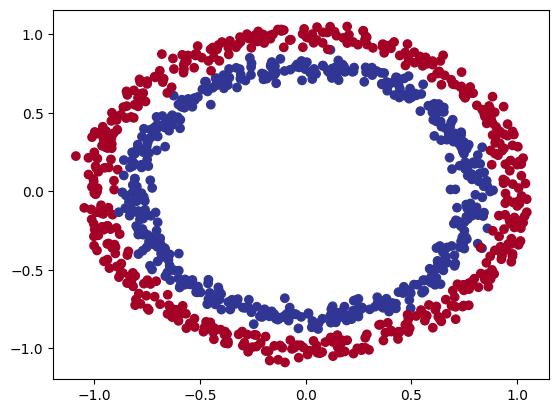

In [116]:
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0], 
            y=X[:, 1], 
            c=y, 
            cmap=plt.cm.RdYlBu);

In [117]:
X.shape, y.shape

((1000, 2), (1000,))

In [118]:
X=torch.from_numpy(X).type(torch.float)
y=torch.from_numpy(y).type(torch.float)

X[:5],y[:5]

(tensor([[ 0.7482,  0.2391],
         [-0.7451,  0.1610],
         [-0.8226,  0.1976],
         [-0.4114,  0.6826],
         [ 0.4439, -0.8958]]),
 tensor([1., 1., 1., 1., 0.]))

In [119]:
# Split data into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, # 20% test, 80% train
                                                    random_state=42) # make the random split reproducible

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

In [120]:
class CircleModel(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.layer1=nn.Linear(in_features=2,out_features=5)
        self.layer2=nn.Linear(in_features=5,out_features=1)
        
        self.relu=nn.ReLU()
    
    def forward(self,x:torch.Tensor) -> torch.Tensor:
        return self.layer2(self.relu(self.layer1(x)))
    

In [121]:
torch.manual_seed(42)
model=CircleModel().to(device)
model

CircleModel(
  (layer1): Linear(in_features=2, out_features=5, bias=True)
  (layer2): Linear(in_features=5, out_features=1, bias=True)
  (relu): ReLU()
)

In [122]:
torch.manual_seed(42)
model0=nn.Sequential(
    nn.Linear(in_features=2,out_features=5),
    nn.ReLU(), #not sure
    nn.Linear(in_features=5,out_features=1),
).to(device)

model0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): ReLU()
  (2): Linear(in_features=5, out_features=1, bias=True)
)

In [123]:
#sequential is better for one way computation but module is better for more control and flexibility

In [124]:
untrained_preds = model(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(y_test)}, Shape: {y_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 test labels:\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200])

First 10 predictions:
tensor([[-0.0994],
        [-0.0820],
        [-0.1902],
        [-0.0699],
        [-0.0944],
        [-0.1031],
        [-0.0824],
        [-0.1303],
        [-0.1928],
        [-0.0803]], device='cuda:0', grad_fn=<SliceBackward0>)

First 10 test labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


In [125]:
untrained_preds = model0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(y_test)}, Shape: {y_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 test labels:\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200])

First 10 predictions:
tensor([[-0.0994],
        [-0.0820],
        [-0.1902],
        [-0.0699],
        [-0.0944],
        [-0.1031],
        [-0.0824],
        [-0.1303],
        [-0.1928],
        [-0.0803]], device='cuda:0', grad_fn=<SliceBackward0>)

First 10 test labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


In [126]:
# loss_fn=nn.BCELoss()
loss_fn=nn.BCEWithLogitsLoss()  ##It has sigmoid layer built in already 
## and documentation states that it's more numerically stable than using torch.nn.BCELoss() after a nn.Sigmoid layer.


optimizer=torch.optim.Adam(params=model.parameters(),lr=0.01)

In [127]:
def accuracy_fn(y_true,y_pred):
    correct=torch.eq(y_true,y_pred).sum().item()
    acc=(correct/len(y_true))*100
    return acc

In [128]:
y_logits = model(X_test.to(device))[:5]
y_logits


tensor([[-0.0994],
        [-0.0820],
        [-0.1902],
        [-0.0699],
        [-0.0944]], device='cuda:0', grad_fn=<SliceBackward0>)

In [129]:
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.4752],
        [0.4795],
        [0.4526],
        [0.4825],
        [0.4764]], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [130]:
y_pred=torch.round(y_pred_probs)
y_pred,y_pred.squeeze(), y_test[:5]

(tensor([[0.],
         [0.],
         [0.],
         [0.],
         [0.]], device='cuda:0', grad_fn=<RoundBackward0>),
 tensor([0., 0., 0., 0., 0.], device='cuda:0', grad_fn=<SqueezeBackward0>),
 tensor([1., 0., 1., 0., 1.]))

In [131]:
X_train,y_train=X_train.to(device),y_train.to(device)
X_test,y_test=X_test.to(device),y_test.to(device)

In [132]:
torch.manual_seed(42)

epochs=1000

for epoch in range(epochs):
    model.train()
    
    y_logits=model(X_train).squeeze()
    y_pred=torch.round(torch.sigmoid(y_logits))
    
    loss=loss_fn(y_logits,y_train) #Using nn.BCEWithLogitsLoss works with raw logits
    acc=accuracy_fn(y_train,y_pred)
    
    optimizer.zero_grad()
    
    loss.backward()
    
    optimizer.step()
    
    model.eval()
    with torch.inference_mode():
        test_logits=model(X_test).squeeze()
        test_pred=torch.round(torch.sigmoid(test_logits))
        
        test_loss=loss_fn(test_logits,y_test)
        test_acc=accuracy_fn(y_test,test_pred)
        
    if (epoch+1)%50==0:
        print(f"Epoch: {epoch+1} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")
    
            
    

Epoch: 50 | Loss: 0.66481, Accuracy: 66.88% | Test loss: 0.66432, Test acc: 69.50%
Epoch: 100 | Loss: 0.58685, Accuracy: 79.12% | Test loss: 0.59954, Test acc: 77.00%
Epoch: 150 | Loss: 0.48733, Accuracy: 87.00% | Test loss: 0.52794, Test acc: 83.00%
Epoch: 200 | Loss: 0.37806, Accuracy: 94.00% | Test loss: 0.42062, Test acc: 91.00%
Epoch: 250 | Loss: 0.27941, Accuracy: 96.25% | Test loss: 0.31626, Test acc: 94.00%
Epoch: 300 | Loss: 0.21843, Accuracy: 97.12% | Test loss: 0.26596, Test acc: 94.00%
Epoch: 350 | Loss: 0.18180, Accuracy: 96.75% | Test loss: 0.23225, Test acc: 93.50%
Epoch: 400 | Loss: 0.15753, Accuracy: 97.12% | Test loss: 0.20996, Test acc: 93.50%
Epoch: 450 | Loss: 0.14054, Accuracy: 97.12% | Test loss: 0.19471, Test acc: 93.50%
Epoch: 500 | Loss: 0.12813, Accuracy: 97.25% | Test loss: 0.18420, Test acc: 93.50%
Epoch: 550 | Loss: 0.11884, Accuracy: 97.25% | Test loss: 0.17628, Test acc: 93.50%
Epoch: 600 | Loss: 0.11167, Accuracy: 97.25% | Test loss: 0.17050, Test acc: 

In [133]:
import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


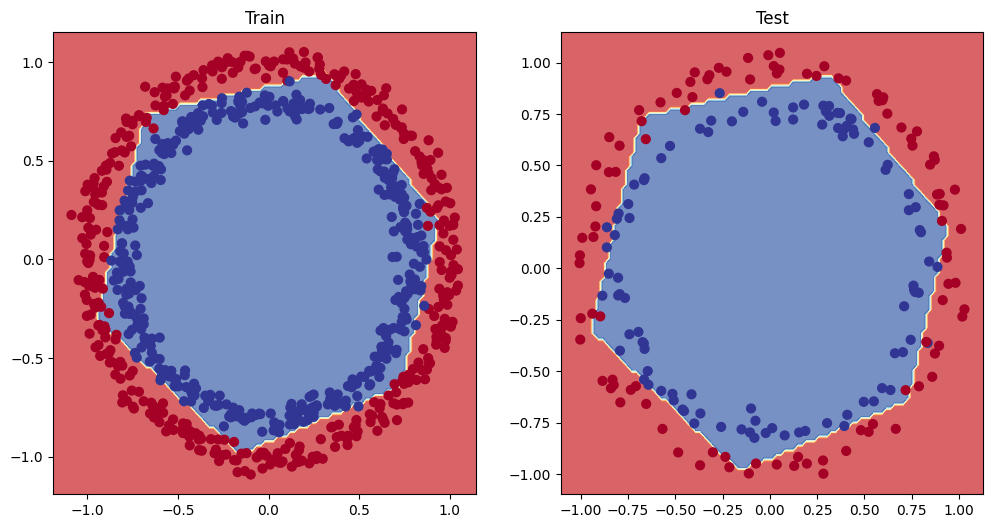

In [134]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model, X_test, y_test)

In [149]:
model.eval()
with torch.inference_mode():
    y_pred=torch.round(torch.sigmoid(model(X_test))).squeeze()

y_pred[:10],y[:10]

(tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0'),
 tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 0.]))

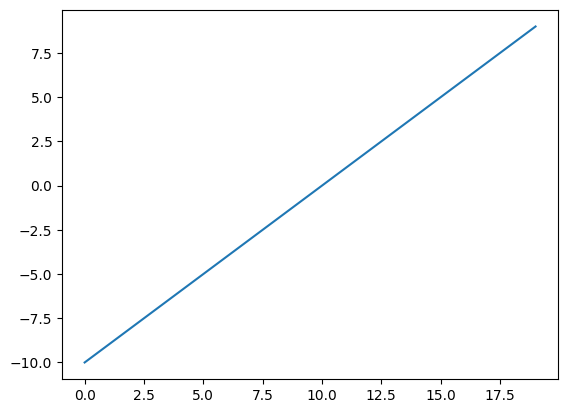

In [151]:
A=torch.arange(-10,10,1, dtype=torch.float32)
A

plt.plot(A);

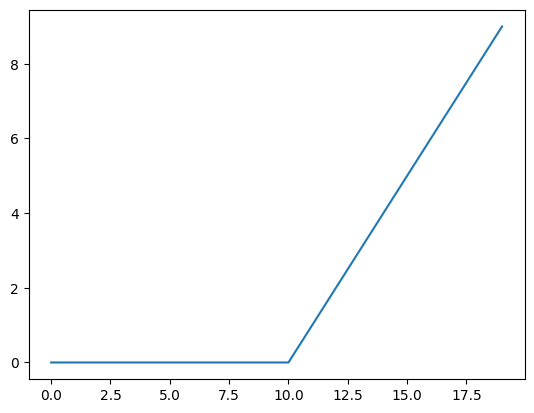

In [154]:
def relu(x):
    return torch.maximum(torch.tensor(0),x)

relu(A) 
plt.plot(relu(A))

In [155]:
def sigmoid(x):
    return 1/(1+torch.exp(-x))

sigmoid(A)

tensor([4.5398e-05, 1.2339e-04, 3.3535e-04, 9.1105e-04, 2.4726e-03, 6.6929e-03,
        1.7986e-02, 4.7426e-02, 1.1920e-01, 2.6894e-01, 5.0000e-01, 7.3106e-01,
        8.8080e-01, 9.5257e-01, 9.8201e-01, 9.9331e-01, 9.9753e-01, 9.9909e-01,
        9.9966e-01, 9.9988e-01])

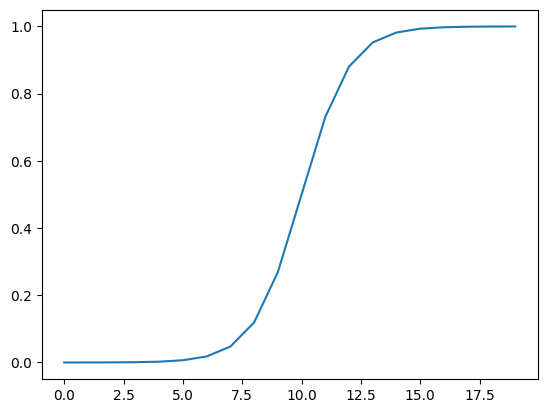

In [156]:
# Plot sigmoid activated toy tensor
plt.plot(sigmoid(A));

In [219]:
from sklearn.datasets import make_blobs

num_classes=4
num_features=2

X_blob, y_blob=make_blobs(n_samples=3000,
                          n_features=num_features,
                          centers=num_classes,
                          cluster_std=1.5,
                          random_state=42)
X_blob=torch.from_numpy(X_blob).type(torch.float)
y_blob=torch.from_numpy(y_blob).type(torch.LongTensor)

X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
    y_blob,
    test_size=0.2,
    random_state=42
)

print(X_blob[:5], y_blob[:5])

tensor([[-6.1487, -5.2722],
        [-2.4435,  8.7938],
        [-4.5595,  8.6771],
        [-1.9671, 11.3213],
        [-9.7437, -4.9027]]) tensor([2, 0, 0, 0, 2])


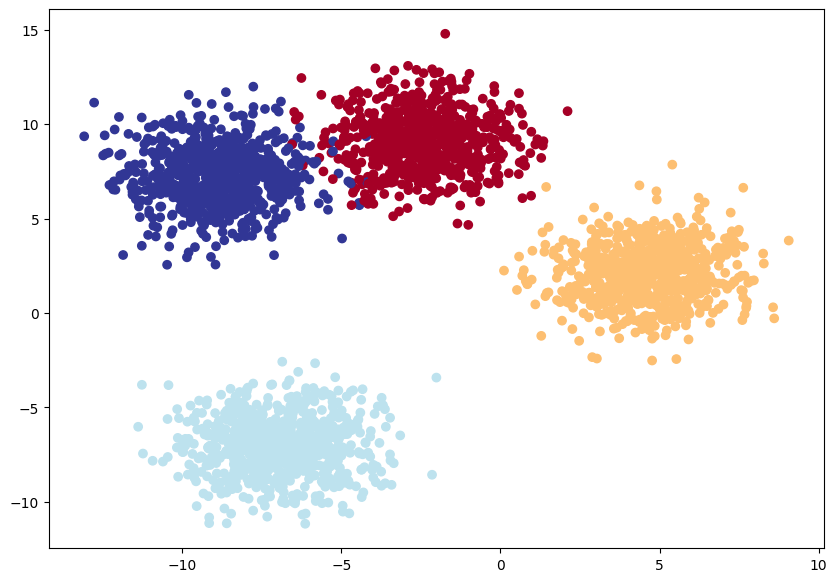

In [220]:
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);

In [221]:
class BlobModel(nn.Module):
    def __init__(self, input_features,output_features,hidden_units=8):
        super().__init__()
        
        self.linear_layer_stack=nn.Sequential(
            nn.Linear(in_features=input_features,out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units,out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units,output_features)
        )
    
    def forward(self,x:torch.Tensor) -> torch.Tensor:
        return self.linear_layer_stack(x)
    

In [222]:
bmodel=BlobModel(input_features=num_features,output_features=num_classes).to(device)
bmodel

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [223]:
loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(params=bmodel.parameters(),lr=0.01)


In [224]:
bmodel(X_blob_train.to(device))[:5]

tensor([[ 0.2528, -0.2379,  0.1882, -0.0066],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.1775, -1.1190, -0.7849, -0.1925],
        [ 0.0925, -0.3337,  0.0785, -0.0628],
        [-0.1469, -1.0494, -0.7193, -0.1777]], device='cuda:0',
       grad_fn=<SliceBackward0>)

In [225]:
bmodel(X_blob_train.to(device))[0].shape, num_classes

(torch.Size([4]), 4)

In [226]:
y_logits=bmodel(X_blob_test.to(device))

y_pred_probs=torch.softmax(y_logits,dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.2026, -1.1523, -0.8978, -0.2635],
        [-0.3147, -1.3931, -1.1726, -0.3524],
        [-0.5003, -0.5672, -1.0865, -0.8353],
        [-0.0878, -0.9248, -0.5683, -0.1249]], device='cuda:0',
       grad_fn=<SliceBackward0>)
tensor([[0.3011, 0.1843, 0.2823, 0.2323],
        [0.3538, 0.1369, 0.1765, 0.3329],
        [0.3667, 0.1247, 0.1555, 0.3531],
        [0.3118, 0.2916, 0.1735, 0.2231],
        [0.3317, 0.1436, 0.2051, 0.3196]], device='cuda:0',
       grad_fn=<SliceBackward0>)


In [227]:
torch.sum(y_pred_probs[0])

tensor(1., device='cuda:0', grad_fn=<SumBackward0>)

In [228]:
print(y_pred_probs[0])
print(torch.argmax(y_pred_probs[0]))

tensor([0.3011, 0.1843, 0.2823, 0.2323], device='cuda:0',
       grad_fn=<SelectBackward0>)
tensor(0, device='cuda:0')


In [229]:
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)


In [230]:
y_blob_test.shape

torch.Size([600])

In [231]:
torch.manual_seed(42)

epochs=100

for epoch in range(epochs):
    bmodel.train()
    
    y_logits=bmodel(X_blob_train)
    y_pred=torch.softmax(y_logits,dim=1).argmax(dim=1)
    
    loss=loss_fn(y_logits,y_blob_train)
    acc=accuracy_fn(y_blob_train,y_pred)
    
    optimizer.zero_grad()
    
    loss.backward()
    
    optimizer.step()
    
    bmodel.eval()
    with torch.inference_mode():
        test_logits=bmodel(X_blob_test)
        test_pred=torch.softmax(test_logits,dim=1).argmax(dim=1)
        
        test_loss=loss_fn(test_logits,y_blob_test)
        test_acc=accuracy_fn(y_blob_test,test_pred)
        
    if (epoch+1 )% 10 == 0:
        print(f"Epoch: {epoch+1} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")
    

Epoch: 10 | Loss: 0.70994, Acc: 85.17% | Test Loss: 0.66492, Test Acc: 95.67%
Epoch: 20 | Loss: 0.39934, Acc: 97.75% | Test Loss: 0.35594, Test Acc: 98.33%
Epoch: 30 | Loss: 0.12356, Acc: 98.92% | Test Loss: 0.10448, Test Acc: 98.83%
Epoch: 40 | Loss: 0.04255, Acc: 99.38% | Test Loss: 0.04113, Test Acc: 99.00%
Epoch: 50 | Loss: 0.02604, Acc: 99.33% | Test Loss: 0.03137, Test Acc: 98.67%
Epoch: 60 | Loss: 0.02171, Acc: 99.33% | Test Loss: 0.02896, Test Acc: 98.67%
Epoch: 70 | Loss: 0.01993, Acc: 99.33% | Test Loss: 0.02848, Test Acc: 98.67%
Epoch: 80 | Loss: 0.01895, Acc: 99.38% | Test Loss: 0.02834, Test Acc: 98.67%
Epoch: 90 | Loss: 0.01830, Acc: 99.38% | Test Loss: 0.02817, Test Acc: 98.67%


Epoch: 100 | Loss: 0.01783, Acc: 99.42% | Test Loss: 0.02815, Test Acc: 98.67%


In [232]:
bmodel.eval()
with torch.inference_mode():
    y_logits=bmodel(X_blob_test)
    
y_logits[:10]

tensor([[-10.2213,  -7.7152,   4.2057,  -8.1893],
        [  3.5346,  -5.8618,  -8.0486,  -5.5308],
        [  4.8827,  -6.3813, -10.5692,  -7.8914],
        [ -8.8541,   2.0432,  -9.6506, -14.5316],
        [ -4.8823,  -8.2838,  -6.4271,   3.1806],
        [ -9.8499,   2.2780, -10.9124, -16.2497],
        [-15.3371,   3.9718, -13.5363, -21.8386],
        [  3.8440,  -4.1018, -13.1206, -11.5345],
        [ -5.6950, -11.4062,  -9.7224,   3.3306],
        [  2.6943,  -2.9817,  -9.2944,  -8.4094]], device='cuda:0')

In [233]:
# Note: It's possible to skip the torch.softmax() function and go straight from predicted logits -> predicted labels by calling torch.argmax() directly on the logits.

# For example, y_preds = torch.argmax(y_logits, dim=1), this saves a computation step (no torch.softmax()) but results in no prediction probabilities being available to use.

In [234]:
y_pred_probs=torch.softmax(y_logits,dim=1)
y_pred=y_pred_probs.argmax(dim=1)

print(f"Predictions: {y_pred[:10]}\nLabels: {y_blob_test[:10]}")
print(f"Test accuracy: {accuracy_fn(y_true=y_blob_test, y_pred=y_pred)}%")

Predictions: tensor([2, 0, 0, 1, 3, 1, 1, 0, 3, 0], device='cuda:0')
Labels: tensor([2, 0, 0, 1, 3, 1, 1, 0, 3, 0], device='cuda:0')
Test accuracy: 98.66666666666667%


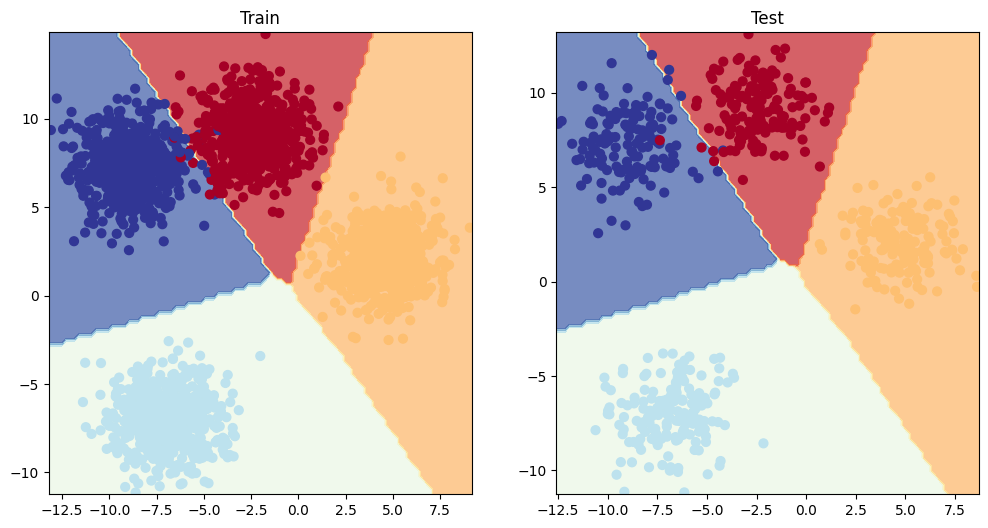

In [235]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(bmodel, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(bmodel, X_blob_test, y_blob_test)

In [240]:
try:
    from torchmetrics import Accuracy
except:
    !pip install torchmetrics 
    # this is the version we're using in this notebook (later versions exist here: https://torchmetrics.readthedocs.io/en/stable/generated/CHANGELOG.html#changelog)
    from torchmetrics import Accuracy

# Setup metric and make sure it's on the target device
torchmetrics_accuracy = Accuracy(task='multiclass', num_classes=4).to(device)

# Calculate accuracy
torchmetrics_accuracy(y_pred, y_blob_test)

tensor(0.9867, device='cuda:0')